In [199]:
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(rlang)
source("src/simulation_scenarios.R")
source("src/hte_caret.R")
source("src/hte_cv.R")
source("src/eval_hte_cv.R")
detach("package:plyr", unload=TRUE)

# Model selection for conditional treatment effect inference
- We have $K$ models $\hat\tau_k(x)$ that estimate the conditional treatment effect $\tau(x) = E[Y|X=x,W=1] - E[Y|X=x,W=0]$ each trained on the same training sample.
- ### Which one do we go with to make future treatment decisions?

# Problem: Outcome prediction error (e.g. CV) doesn't target treatment effect

## Example:
- Assume a true model $y = \beta*x + \tau*w + \epsilon$ where $x,w \in\{0,1\}$ and $|\beta| > |\tau|$
- Let's say we have two candidate models: $y = \beta*x$ (meaning $\hat\tau=0$) and $y = \tau*w$ (meaning $\hat\tau=\tau$)
- If we use test set prediction error to select between these two models, $y = \beta*x$ will win! But it gives us a much worse estimate of the treatment effect.

# Synth-Validation
### Synth-validation is supposed to solve this problem, but...
- Generative model choice will bias model selection more in HTE setting
- Computationally expensive
- Difficult to understand, tuning parameters

# Rob's HTE Model Selection Idea: "HTE-CV"

- We have $K$ models $\hat\tau_k(x)$ that estimate the conditional treatment effect $\tau(x) = E[Y|X=x,W=1] - E[Y|X=x,W=0]$ each trained on the same training sample.
- Use these models to get estimates on a test sample: $\mathbf{\hat\tau_k} = [\hat\tau_k(x_1), \hat\tau_k(x_2) \dots \hat\tau_k(x_n)]$
- For each model, split up the observations in that vector into Q quantiles: $S_{k,q} = \{x_i | \hat\tau_k(x_i) \in$ $q$th quantile of $\mathbf{\hat\tau_k}\}$
- In each quantile for each model, calculate the average of the estimated conditional effects: $\bar\tau_{k,q} = \frac{1}{|S_{k,q}|}\sum_{x_i \in S_{k,q}} \hat\tau_k(x_i)$
- In each quantile for each model, estiamte the average treatment effect using a simple difference of means: $\gamma_{k,q} = \frac{1}{|S_{k,q,W=1}|}\sum_{x_i \in S_{k,q,W=1}} y_i - \frac{1}{|S_{k,q,W=0}|}\sum_{x_i \in S_{k,q,W=0}} y_i$ (where $S_{k,q,W=w} = S_{k,q} \cap \{x_i|w_i=w\}$)
- Take the squared difference between these two estimates and sum them up across quantiles for each model: $\hat{e}_k = \sum_q (\bar\tau_{k,q} - \gamma_{k,q})^2$. Use this as an estimate of the error in estimating the HTE.
- The model with the lowest value is selected: $k^* = \underset{k}{\text{argmin}} \ \  \hat{e}_k$
- Do this in a round-robin fashion on a training set to get HTE-CV

In [213]:
setup = setup_simulation(3) 
setup$params$p = 10 # for efficiency
effect_function = setup$functions$effect

data = create_data(setup)
true_effect = data %>% select(starts_with("covariate")) %>% effect_function
train_index = create_train_index(data, n_folds=2)

method = "xgbTree"
tune_grid = expand.grid(nrounds = seq(1,501,50), max_depth = c(3), eta = 0.2)

test_estimates = cross_estimate_hte(data, method, tune_grid, train_index) %>% 
    inner_join(data.frame(true_effect, subject=data$subject), by="subject")

# An example: Test set effect predictions and observed outcomes

In [254]:
options(repr.plot.width=10, repr.plot.height=5)

plot_data = test_estimates %>% 
    filter(nrounds == 501 | nrounds == 51) %>%
    group_by(nrounds) %>%
    mutate(strata = ntile(effect, 5)) %>%
    dplyr::arrange(effect) %>%
    mutate(patient = row_number())
cutoffs = plot_data %>% 
    group_by(strata) %>%
    filter(patient==max(patient)) %>%
    pull(patient) %>% c(0)

plot = plot_data %>%
ggplot(aes(x=patient)) + 
    geom_point(aes(y=outcome, color=treatment)) + 
    geom_vline(xintercept=cutoffs) + 
    geom_point(aes(y=true_effect), shape="o", color="yellow") + 
    geom_point(aes(y=effect), size=1) + 
    facet_wrap(~nrounds)

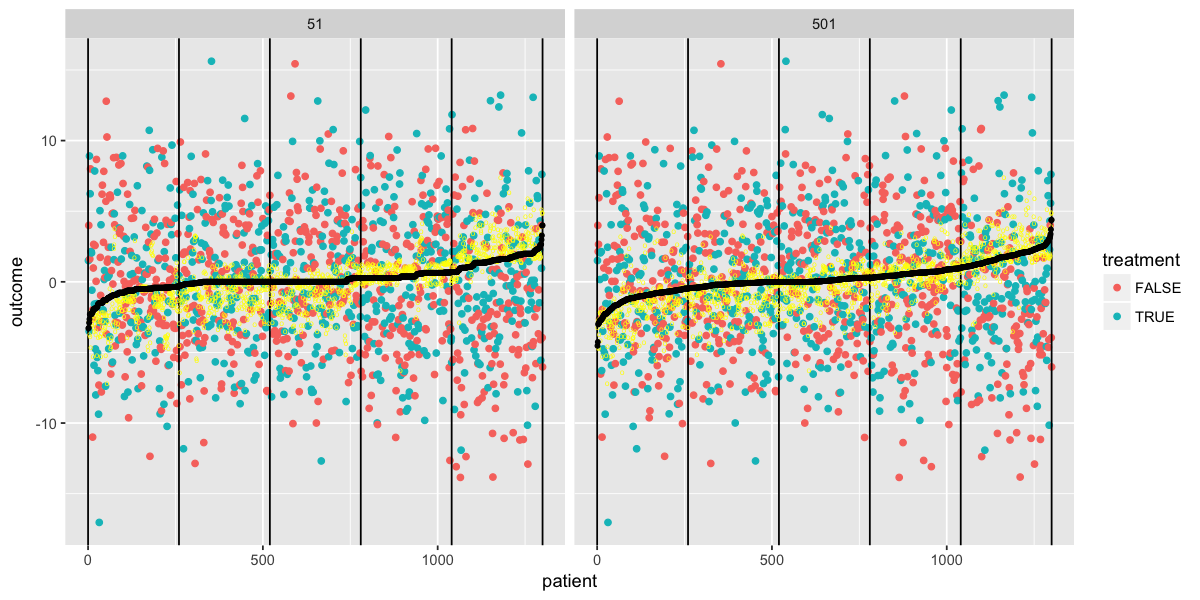

In [255]:
plot

In [256]:
plot = plot_data %>% 
    dplyr::group_by(nrounds, strata) %>%
    dplyr::summarize(mean_hte_estimate = mean(effect),
              mean_treated_outcome = sum(outcome*treatment)/sum(treatment),
              mean_control_outcome = sum(outcome*!treatment)/sum(!treatment),
              n_in_strata = n()) %>%
    dplyr::mutate(te_estimate = mean_treated_outcome - mean_control_outcome,
                  error = n_in_strata*(mean_hte_estimate - te_estimate)^2) %>%
    inner_join(plot_data, by=c("strata", "nrounds")) %>%
ggplot(aes(x=patient)) + 
    geom_point(aes(y=effect)) + 
    geom_line(aes(y=te_estimate)) + 
    geom_vline(xintercept=cutoffs) + 
    facet_wrap(~nrounds)

# An example: Test set effect predictions and observed outcomes

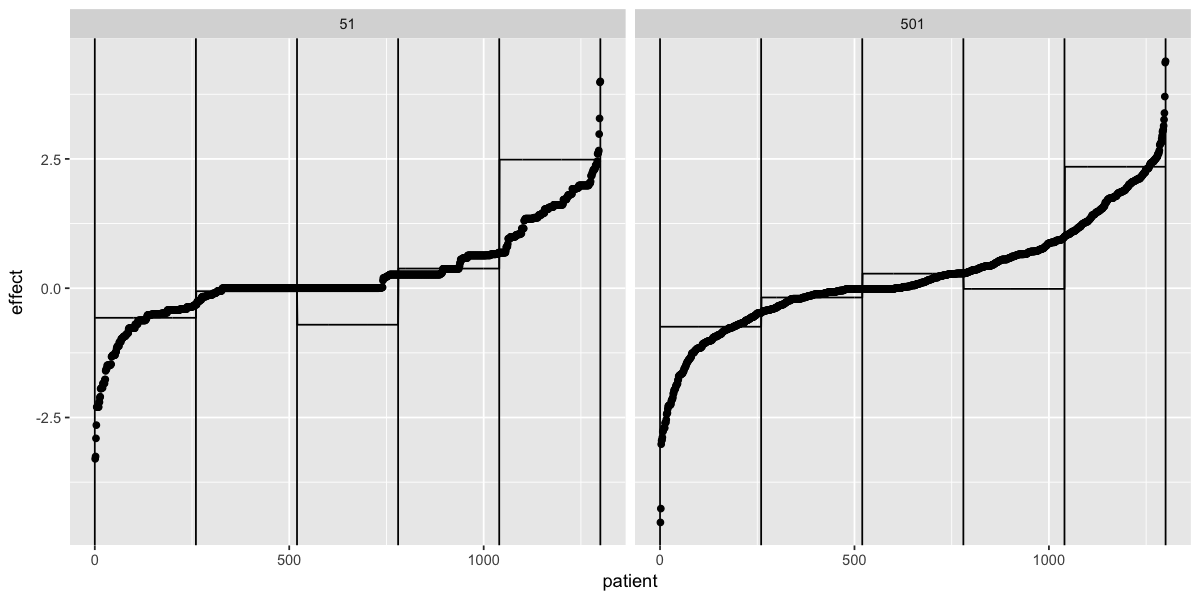

In [257]:
plot

In [261]:
test_errors = estimate_test_errors(test_estimates, names(tune_grid), 5)
plot = test_errors %>%
    gather(error_type, error, prediction_cv, true_error, hte_cv) %>%
ggplot(aes(x=nrounds, y=error)) +
    geom_line(aes(color=error_type)) +
    facet_grid(error_type~., scales="free_y")

# Comparing prediction CV with HTE CV across a range of boosting models

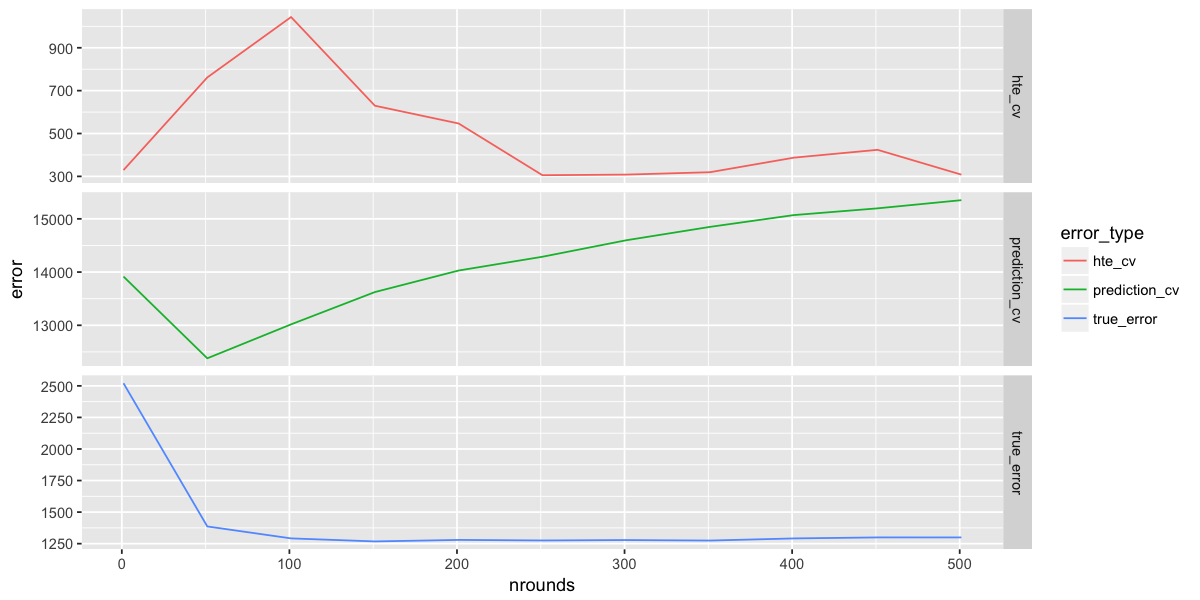

In [262]:
plot

In [200]:
# methods = list("xgbTree",
#                "derp")
# tune_grids = list(expand.grid(nrounds = seq(1,501,50), max_depth = c(3), eta = 0.2),
#                   expand.grid(lambda=0:20))
# models = list(methods, tune_grids) %>%
#     pmap(~list(method=.x, tune_grid=.y))

model = list(method="xgbTree",
             tune_grid=expand.grid(nrounds = seq(1,501,50), max_depth = c(3), eta = 0.2))
simulation_params = list(scenario=9:16, 
                         n_folds=c(3,5,10,20), 
                         n_strata=c(3,5,10),
                         rep = 1:3) %>% 
    cross

In [201]:
loop_test = function(scenario, n_folds, n_strata, rep, model) {
    setup = setup_simulation(scenario) 
    setup$params$p = 10 # for efficiency
    effect_function = setup$functions$effect
    
    data = create_data(setup)
    true_effect = data %>% select(starts_with("covariate")) %>% effect_function
    train_index = create_train_index(data, n_folds=n_folds)
    
    # loop over models in the future. For now assume one method, one tune grid
    test_estimates = cross_estimate_hte(data, model$method, model$tune_grid, train_index) %>% 
        inner_join(data.frame(true_effect, subject=data$subject), by="subject")

    test_errors = estimate_test_errors(test_estimates, names(model$tune_grid), n_strata)
    min_test_errors = est_errors_selected(test_errors) %>%
        mutate(scenario=scenario, n_folds=n_folds, n_strata=n_strata, rep=rep) %>%
        mutate(rel_true_error = (true_error+1)/(min(true_error)+1))
    
    return(min_test_errors)
}

In [202]:
results = simulation_params %>% 
    map(~loop_test(.$scenario, .$n_folds, .$n_strata, .$rep, model)) %>%
    bind_rows()

# Comparing the HTE-estimation error of prediction-CV and HTE-CV relative to an oracle selector, across a range of simulations

#### Using 10 folds, 5 strata

In [271]:
options(repr.plot.width=10, repr.plot.height=7)
plot = results %>%
    filter(n_folds == 10, n_strata==5) %>%
ggplot(aes(x=as.factor(scenario), y=rel_true_error, color=model_selection)) +
    geom_boxplot() + 
    facet_grid(n_folds ~ n_strata)

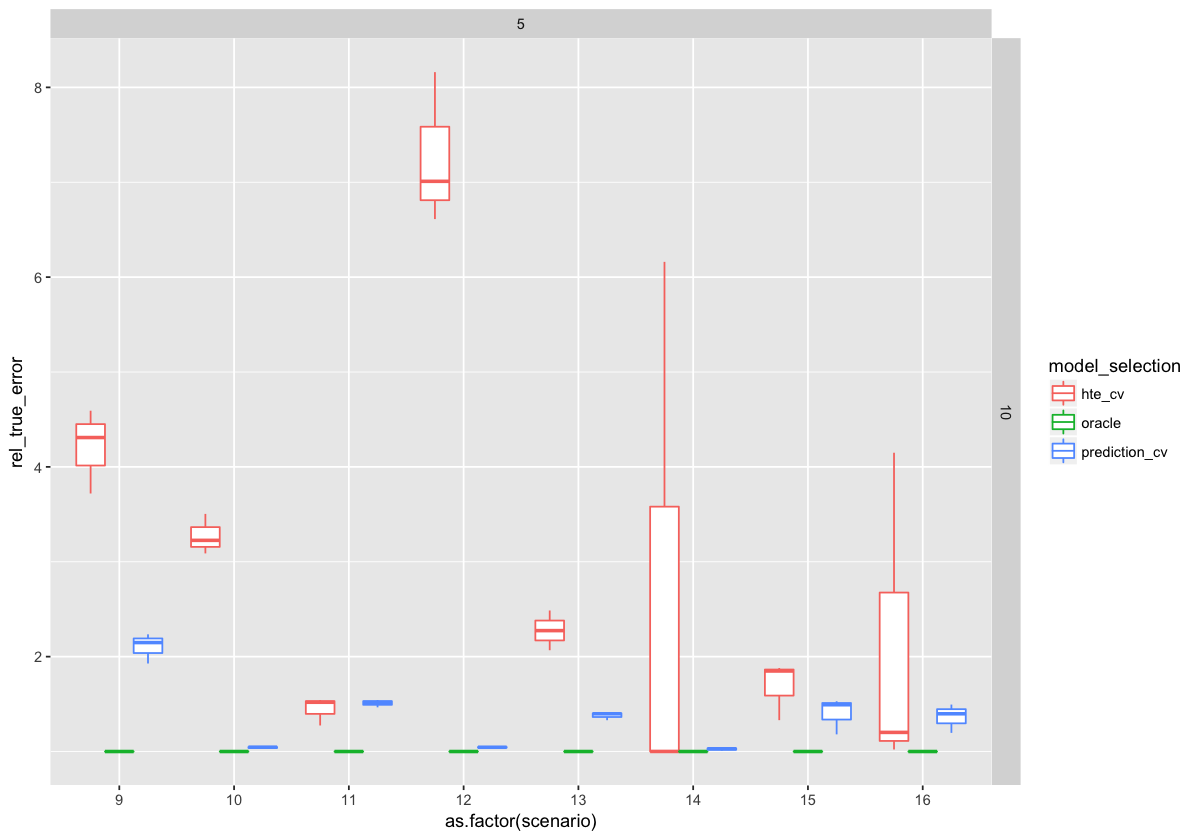

In [272]:
plot

# Comparing the HTE-estimation error of prediction-CV and HTE-CV relative to an oracle selector, across a range of simulations

In [273]:
options(repr.plot.width=10, repr.plot.height=7)
plot = results %>%
ggplot(aes(x=as.factor(scenario), y=rel_true_error, color=model_selection)) +
    geom_boxplot() + 
    facet_grid(n_folds ~ n_strata)

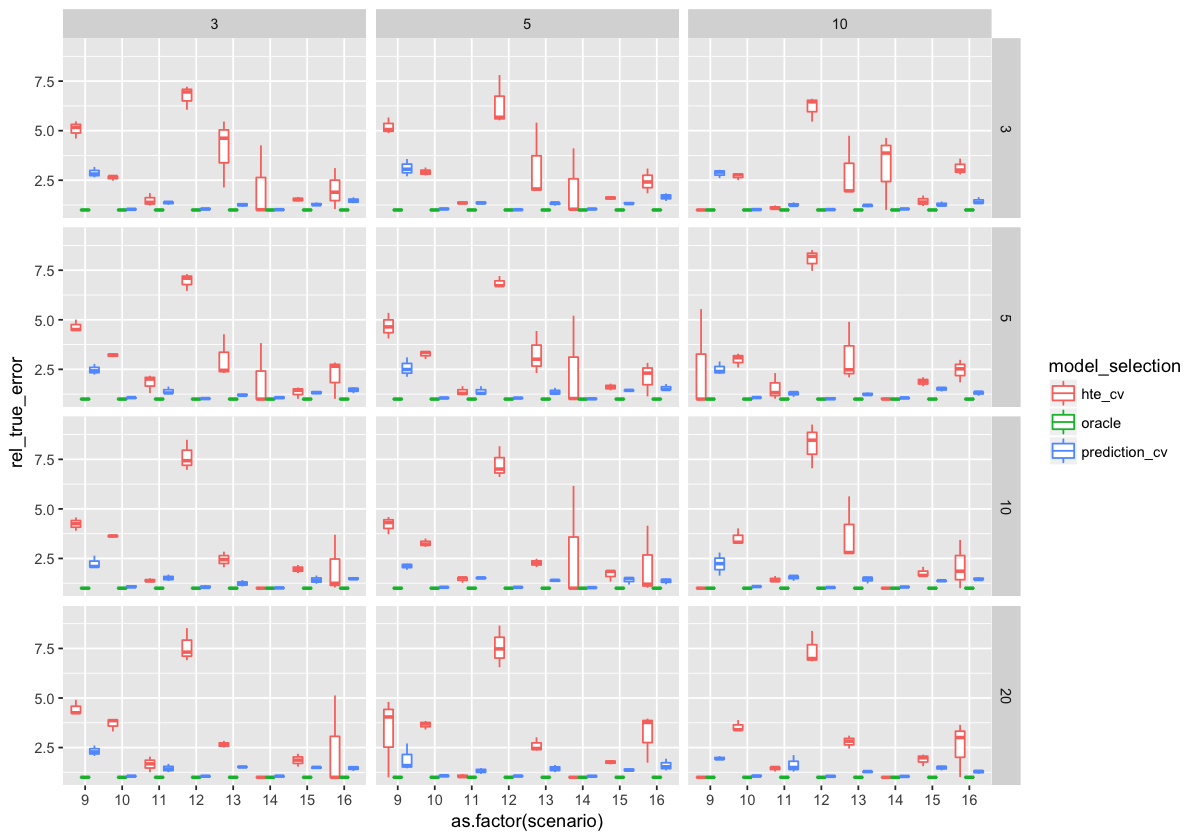

In [274]:
plot